## Dimostrazione
$L_{oss} = L_{lente} + A\cdot L_{sorg}$ <br>
$ m = -2.5\cdot log_{10}\left(\frac{L}{L_{ref}}\right)$ <br>

$m_{sorg} = -2.5\cdot log_{10}\left(\frac{L_{sorg}}{L_{ref}}\right)$ da cui $L_{sorg} = 10^{-\frac{m_{sorg}}{2.5}}\cdot L_{ref}$ <br>
Analogo per $L_{lente}$ ed $L_{oss}$: <br>$L_{lente} = 10^{-\frac{m_{lente}}{2.5}}\cdot L_{ref}$ <br> $L_{oss} = 10^{-\frac{m_{oss}}{2.5}}\cdot L_{ref}$<br> Ricordando che $f = \frac{L_{sorg}}{L_{sorg} +  L_{lente}}$ allora: <br>
$f = \frac{10^{-\frac{m_{sorg}}{2.5}}\cdot L_{ref}}{10^{-\frac{m_{sorg}}{2.5}}\cdot L_{ref} + 10^{-\frac{m_{lente}}{2.5}}\cdot L_{ref}}$ = $\frac{10^{-\frac{m_{sorg}}{2.5}}}{10^{-\frac{m_{sorg}}{2.5}} + 10^{-\frac{m_{lente}}{2.5}}}$<br>Ora trovo $m_{lente}$:<br>



$10^{-\frac{m_{oss}}{2.5}}\cdot L_{ref}$ = $10^{-\frac{m_{oss}}{2.5}}\cdot L_{ref}$ + $10^{-\frac{m_{sorg}}{2.5}}\cdot L_{ref}$



In [2]:
from astropy.table import Table
import emcee
import corner
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
import datetime
import lmfit

In [3]:
!pip install lmfit

In [4]:
data = Table.read("ftp://ftp.astrouw.edu.pl/ogle/ogle4/ews/2014/blg-0021/phot.dat", format = "ascii" )

In [5]:
data # col1 = tempo in JD, col2 = magnitudine osservata, col3 = err mag

<Table length=6375>
     col1       col2    col3    col4    col5 
   float64    float64 float64 float64 float64
------------- ------- ------- ------- -------
2455260.86264  15.215   0.003    4.17   683.0
2455260.90627   15.22   0.004    4.18  1520.0
2455262.83592  15.215   0.006    6.04  2538.0
2455264.82055  15.219   0.003     5.0   680.0
2455264.87365  15.219   0.004     5.0   654.0
2455264.89096   15.22   0.003     4.5   662.0
2455265.79657  15.217   0.003    4.75   476.0
2455266.78464  15.223   0.003    5.07   537.0
2455267.82646  15.219   0.003    4.67   445.0
2455268.79771  15.222   0.003    4.94   476.0
          ...     ...     ...     ...     ...
2456947.48761  15.217   0.004    7.45   926.0
2456947.52843  15.224   0.004    8.77   569.0
2456948.53074  15.234   0.004    9.88   601.0
2456950.54117  15.229   0.004    8.09   637.0
2456950.55449  15.226   0.004    7.88   633.0
2456951.53154  15.219   0.004    8.43   617.0
2456952.53764  15.225   0.004    7.61   661.0
2456954.49636  15.222   0.004    8.05   818.0
2456955.50762  15.225   0.004     7.0   609.0
2456956.52001  15.208   0.004    7.59   640.0

## Dati

Noi abbiamo alcuni dati come f o umin, t_e. Però comuqnue noi ipotizzaimo una serie di valori (come fatto con b) e vediamo se risulatano compatibili con tali dati. Se uno scrive la formula della lakilihood not che e una gaussiana tipo a forma di luce...quindi con picco verso il basso.

$m_{oss} = m_{tot} - 2.5\cdot\log_{10}(1-f+A\cdot f)$  non è la likelihood<br>
$m_{tot} = m_{lente} + m_{sorgente}$ <br>
$A = \frac{u^2+2}{u\sqrt{u^2+4}}$ <br>
$u(t) = \sqrt{u_{min}^2+\left(\frac{t - t_0}{t_E}\right)^2}$ <br>
$L_{oss} = L_{lente} + A\cdot L_{sorg}$

In [6]:
# likelihhod = probabilità di un set di dati, dati i paramentri del modello
# VEDERE SITO FITTING A MODEL EMCEE.
def SLDistant_Quad(t, t_min, t_e, u_min): #u^2
    return u_min**2 + ((t - t_min)/(t_e))**2

def Amplification(u_2): #u è da pensare come u^2
    return (u_2+2)/np.sqrt(u_2*(u_2+4))

def log_likelihood(par, t, y, yerr): # t è il tempo...le mie x. y e la magnitudine...le y. yerr è le'rrore sulla mag.
    t_min, t_e, u_min, fbl, m_tot = par
    model = m_tot -2.5*np.log( fbl*Amplification(SLDistant_Quad(t, t_min, t_e, u_min)) + 1 - fbl)/np.log(10) # model è il notro modello: noi abbiamo dei dati che pensiamo siano distributit secondo una gaussina. Quindi nella likelihood noi mettiamo una gaiussiana con valore medio il nostro modello.
    return -0.5*np.sum(np.log(2*np.pi*yerr) + ((y - model)/(yerr))**2)

def log_prior(par):
    t_min, t_e, u_min, fbl, m_tot = par
    if 2456720 < t_min < 2456730 and 40 < t_e < 50 and 0 < u_min < 1 and 0 < fbl < 1 and 13 < m_tot < 17:
        return -np.log(10*10*4) #lo metto come mi pare. supponiamo che siano indipendenti.
    return -np.inf

def log_postirior(per, x, y, yerr):
    lp = log_prior(per)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(per, x, y, yerr)


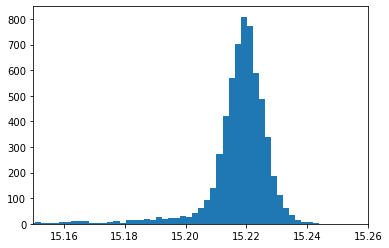

In [7]:
fig,ax=plt.subplots(1,1);
c1 = ax.hist(data['col2'], bins = 1000);
ax.set_xlim(15.15, 15.26);

AttributeError: 'PathCollection' object has no property 'capsize'

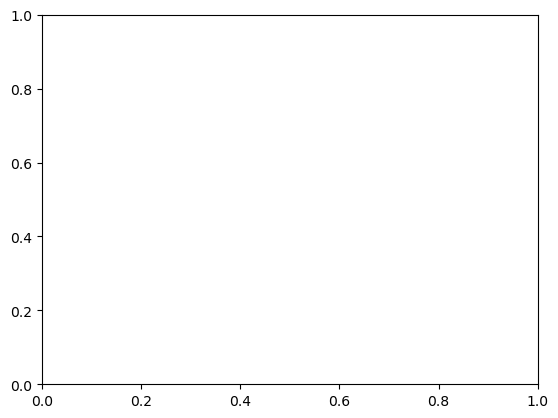

In [36]:
#x = [y for y in np.exp(data['col1']) if (y >= ) ]
''''plt.style.use('default')
plt.scatter(data['col1']-2455265, data['col2'], capsize=0, s = 1)
#plt.plot(data['col1']-2455265,data['col2'],"g", alpha=0.8, lw=1)
plt.gca().invert_yaxis()
#plt.xlim(1200, 1700);
plt.xlabel("HJD - 2455265")
plt.ylabel("magnitude");
plt.vlines(2456400 - 2455265, 15.25, 13.25, color = 'red', linestyle = 'dashed')
plt.vlines(2456956.52001 -2455265 , 15.25, 13.25, color = 'red', linestyle = 'dashed')'''
plt.scatter(ts_grezzo, ms_grezzo, 2.5, color = 'black');
plt.xlabel("EJD")
plt.ylabel("")
plt.vlines(2456400, 15.25, 13.25, color = 'red', linestyle = 'dashed')
plt.vlines(2456956.52001, 15.25, 13.25, color = 'red', linestyle = 'dashed')
plt.gca().invert_yaxis()

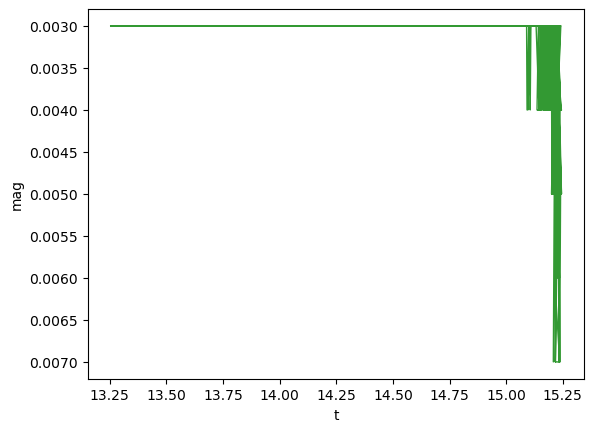

In [31]:
plt.style.use('default')
#plt.errorbar(data['col1']-2455265, data['col2'], yerr=data['col3'], fmt=".k", capsize=0)
plt.plot(data['col2'],data['col3'],"g", alpha=0.8, lw=1)
plt.gca().invert_yaxis()
#plt.xlim(1200, 1550);
plt.xlabel("t")
plt.ylabel("mag");

In [71]:
par = [2456724.643, 42.837, 0.148, 0.887,15.350]
log_likelihood(par, data['col1'], data['col2'], data['col3'])

-5389511.907878415

Maximum likelihood estimates:
t_E = 42.768
U_min = 0.084
f_bl = 0.859
m_tot = 15.186
t_0_min = 2456724.635


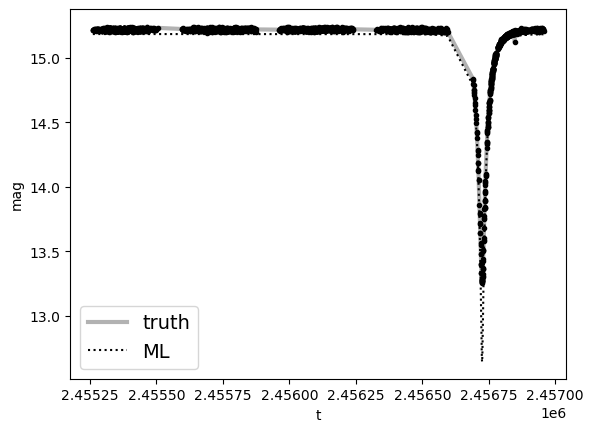

In [72]:

from scipy.optimize import minimize

t_E_true = 42.837
U_min_true = 0.148
f_bl_true = 0.887
m_tot_true = 15.350
t_0_min_true = 2456724.643 # Valore t - 2456724

nll = lambda *args: -log_likelihood(*args) # lambda funcition
initial = np.array([t_0_min_true, t_E_true, U_min_true, f_bl_true, m_tot_true]) + 0.1 * np.random.randn(5)
soln = minimize(nll, initial, args=( np.sort(10 * np.random.rand(6375)), data['col2'], data['col3']))
t_0_min, t_E_model, U_min_model, f_bl_model, m_tot_model  = soln.x

# np.sort(10 * np.random.rand(6375))

print("Maximum likelihood estimates:")
print("t_E = {0:.3f}".format(t_E_model))
print("U_min = {0:.3f}".format(U_min_model))
print("f_bl = {0:.3f}".format(f_bl_model))
print("m_tot = {0:.3f}".format(m_tot_model))
print("t_0_min = {0:.3f}".format(t_0_min))

plt.errorbar(data['col1'], data['col2'], yerr=data['col3'], fmt=".k", capsize=0)
plt.plot(data['col1'],data['col2'], "k", alpha=0.3, lw=3, label="truth")
model =  m_tot_model -2.5*np.log(f_bl_model*Amplification(SLDistant_Quad(data['col1'], t_0_min, t_E_model, U_min_model)) + 1 - f_bl_model)/np.log(10)
plt.plot(data['col1'],  model, ":k", label="ML")


# np.dot fa il prodotto di due array
# np.vander prende come impunt un array 1D e il numero di colonne di outpu(5) e restituisce una matrice tale che nella prima colonna
# ho il vettore che ho passato elevato alla N-1. La seconda colonna ho il vettore elevato alla N-2 e cosè via.

plt.legend(fontsize=14)
plt.xlabel("t")
plt.ylabel("mag");

In [73]:
import emcee

#soln = [t_0_min, t_E_model, U_min_model, f_bl_model, m_tot_model]
pos = soln.x + 1e-4 * np.random.randn(25, 5) # perche devo cambiare questi valori? 25 walkers (almeno il doppio dei numeri di paramentri )
nwalkers, ndim = pos.shape # nwalkers gli ascegna 25

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_postirior, args=(data['col1'], data['col2'], data['col3'])
)
sampler.run_mcmc(pos, 5000, progress=True);


100%|██████████| 5000/5000 [01:08<00:00, 73.39it/s]


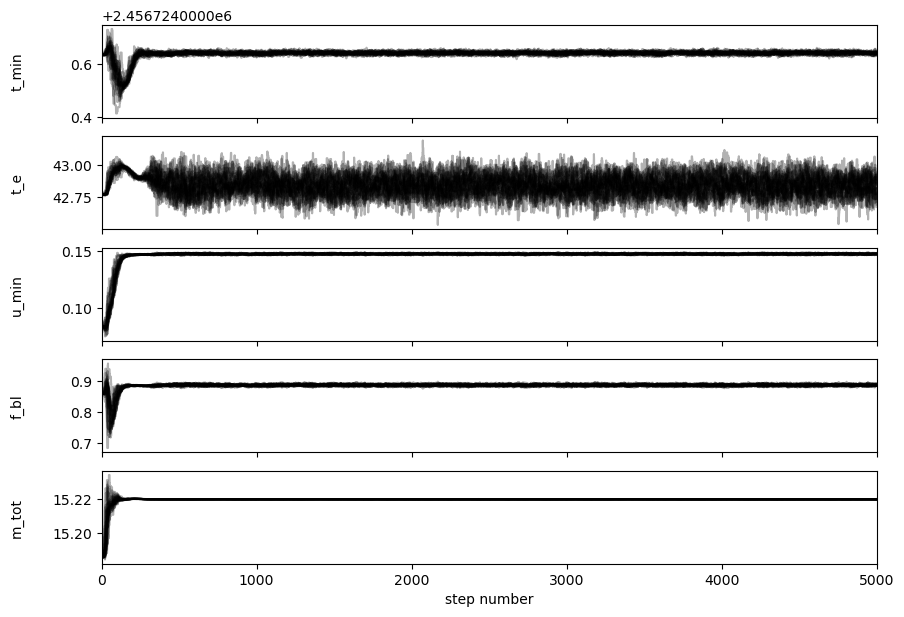

In [76]:
#i grafici sono il percorso del camminatore.

fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["t_min", "t_e", "u_min", "f_bl", "m_tot"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, 5000)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

(8150, 5)


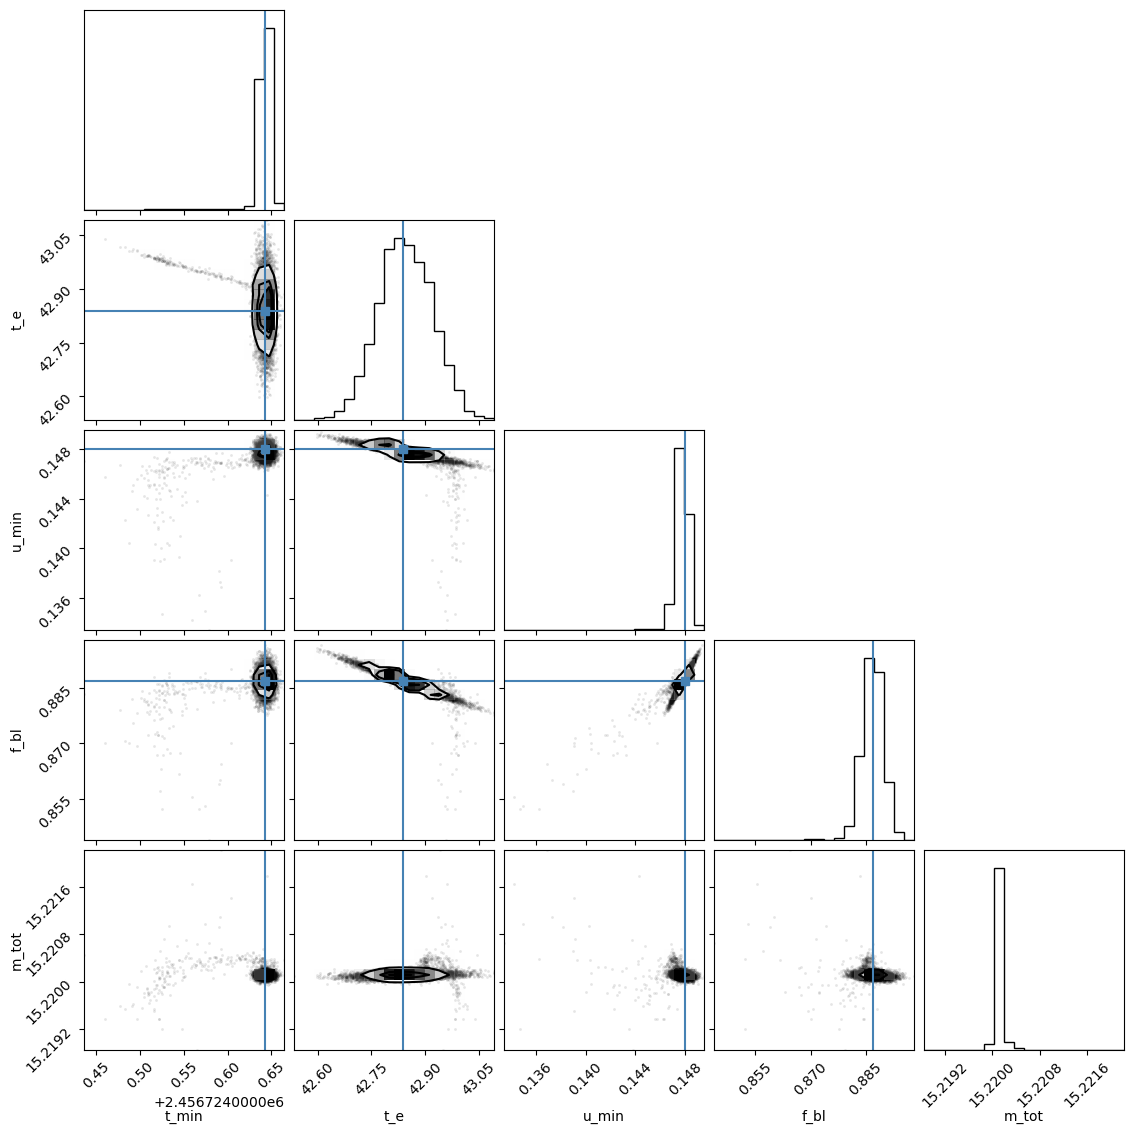

In [77]:
import corner

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

fig = corner.corner(
    flat_samples, labels=labels, truths=[t_0_min_true, t_E_true, U_min_true, f_bl_true,m_tot_true]
);


In [82]:
result_emcee = model.fit(data=y, x=x, params=emcee_params, method='emcee',
                         nan_policy='omit', fit_kws=emcee_kws)
print("\nmedian of posterior probability distribution")
print('--------------------------------------------')
lmfit.report_fit(result_emcee.params)


median of posterior probability distribution
--------------------------------------------


NameError: name 'result_emcee' is not defined

In [85]:
import corner
import matplotlib.pyplot as plt
import numpy as np

import lmfit

In [86]:
data = Table.read("ftp://ftp.astrouw.edu.pl/ogle/ogle4/ews/2014/blg-0021/phot.dat", format = "ascii" )

In [88]:
def SLDistant_Quad(t, t_min, t_e, u_min): #u^2
    return u_min**2 + ((t - t_min)/(t_e))**2

def Amplification(u_2): #u è da pensare come u^2
    return (u_2+2)/np.sqrt(u_2*(u_2+4))

def log_likelihood(par, ts, ms, ms_err):
    
    t_min, tE, u_min, fbl, m_tot = par
    
    model = m_tot - 2.5*np.log10(fbl*magnification(u2(ts, u_min, t_min, tE)) + 1 - fbl)
    
    return ( - 0.5 * np.sum( np.log(2*np.pi*ms_err**2) + (( ms - model ) / ms_err )**2) ) 

def log_prior (par):
    
    t_min, tE, u_min, fbl, m_tot = par
    
    if t_min < t_min_sx or t_min > t_min_dx or tE < tE_sx or tE > tE_dx or u_min < u_min_sx or u_min > u_min_dx or fbl < fbl_sx  or fbl > fbl_dx or m_tot < m_tot_sx or m_tot > m_tot_dx:
        return -np.inf
    else:
        return -np.log((t_min_dx - t_min_sx)*(tE_dx - tE_sx)*(u_min_dx - u_min_sx )*(fbl_dx - fbl_sx)*(m_tot_dx - m_tot_sx ))
    
def log_posterior (par, xs, ys, sigmas):
    lp = log_prior(par)
    
    if np.isfinite(lp):
        return lp + log_likelihood(par, ts, ms, ms_err)
    else:
        return lp

In [89]:
modello = lmfit.Model(log_likelihood)